
ANALISI CONDOTTA CON LA FEATURE error rate (PASSATA A BOOLEAN OUTCOME)

In [327]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch

      
from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor       

In [328]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)

In [329]:
seed = 42
pd.options.display.float_format = '{:.3f}'.format


In [330]:
pruning = 0.01

In [331]:
min_sup = 0.15
percentage = 5

In [332]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [333]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [334]:
#GDecisioN tree predictions
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = RandomForestClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()

In [335]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [336]:
#predizioni per il validation set
y_pred_val_dt = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val_dt

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [337]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

In [338]:
#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['error'] = (df_val_class['y_val_true'] != df_val_class['y_pred']).astype(int)
df_val.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,y_pred,error
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,0,0
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,0,1
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,0,0
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,1,0
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,0,0


In [339]:
error_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by=["error_div", "error_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,error,error_div,error_t,length,support_count
0,0.159,"(race= White, sex= Male, marital-status=Married, relationship= Husband, native-country=United-States, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.400,0.243,15.306,9,1034.000
1,0.159,"(race= White, sex= Male, relationship= Husband, native-country=United-States, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.400,0.243,15.306,8,1034.000
2,0.159,"(race= White, marital-status=Married, relationship= Husband, native-country=United-States, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.400,0.243,15.306,8,1034.000
3,0.159,"(race= White, relationship= Husband, native-country=United-States, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.400,0.243,15.306,7,1034.000
4,0.161,"(race= White, sex= Male, marital-status=Married, native-country=United-States, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.398,0.241,15.282,8,1050.000


In [340]:
#pruning 
error_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = error_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()

,support,itemset,length,support_count,error,error_div,error_t
6,0.239,"(race= White, relationship= Husband, native-country=United-States, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",6,1554.000,0.393,0.235,17.841
18,0.172,"(race= White, relationship= Husband, native-country=United-States, workclass=Private, capital-gain=0.0, capital-loss=0.0)",6,1122.000,0.389,0.232,15.242
21,0.262,"(race= White, marital-status=Married, native-country=United-States, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",6,1707.000,0.386,0.229,18.125
35,0.258,"(relationship= Husband, native-country=United-States, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",5,1679.000,0.381,0.223,17.606
36,0.197,"(race= White, marital-status=Married, native-country=United-States, workclass=Private, capital-gain=0.0, capital-loss=0.0)",6,1285.000,0.380,0.222,15.592


In [341]:
# Numero totale di istanze
total_instances = len(df_pruned_error)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_error[(df_pruned_error['error_div'] > 0) & (df_pruned_error['error_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 196
total problematic 166


In [342]:
prun_size = df_pruned_error.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (1655, 7)
Dim pruned th_redundancy  (196, 7)


In [343]:
K = int((percentage / 100) * filtered_instances)
K

8

BIAS MITIGATION

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [344]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_holdout, K) #da aggiungere a train set e ripetere train e test

df_combinated = pd.concat([df_holdout_filtered, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)


In [345]:
print(len(df_holdout_filtered))

2126


In [346]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  15140
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  2126
TEST SET FILTERED ROWS:  6507


In [347]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = RandomForestClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()

In [348]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = RandomForestClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)



2126
verifica : 2126


In [349]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
"After Mitigation(K=5, fp)",0.842,0.658,0.091,0.369,448,579,15140,6508
After RANDOM mitigation,0.840,0.650,0.088,0.385,436,604,15140,6508


Performance su sottogruppi 

In [350]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_error, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fp")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fp


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.665,0.553,0.251,0.467,330,392,13014,2154
"After Mitigation(K=5, on subgroups, fp)",0.667,0.568,0.266,0.437,350,367,15140,2154
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.666,0.556,0.252,0.464,331,389,15140,2154


ANALISI DIVERGENZE


Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [351]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_no_mitigation  = df_pruned_error["error_div"].tolist()
#error_div_list_no_mitigation

#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_baseline1

#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_random_per_confrontare_con_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_random_per_confrontare_con_baseline1

# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_error_div_list_no_mitigation = np.nanmean(error_div_list_no_mitigation)
media_error_div_list_nomitigation_primi10 = np.nanmean(error_div_list_no_mitigation[:10])
media_error_div_list_nomitigation_primi20 = np.nanmean(error_div_list_no_mitigation[:20])
media_error_div_list_nomitigation_primi40 = np.nanmean(error_div_list_no_mitigation[:40])
massimo_valore_assoluto_error_div_no_mitigation = max(abs(x) for x in error_div_list_no_mitigation)

media_error_div_list_baseline1 = np.nanmean(error_div_list_baseline1)
media_error_div_list_baseline1_primi10 = np.nanmean(error_div_list_baseline1[:10])
media_error_div_list_baseline1_primi20 = np.nanmean(error_div_list_baseline1[:20])
media_error_div_list_baseline1_primi40 = np.nanmean(error_div_list_baseline1[:40])
error_div_massimo_valore_assoluto_error_div_baseline1 = max(abs(x) for x in error_div_list_baseline1)

media_error_div_list_random_per_confrontare_con_baseline1 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1)
media_error_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:10])
media_error_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:20])
media_error_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in error_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_correctness_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_error_div_list_no_mitigation, massimo_valore_assoluto_error_div_no_mitigation,
        media_error_div_list_nomitigation_primi10, media_error_div_list_nomitigation_primi20, media_error_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_error_div_list_baseline1, error_div_massimo_valore_assoluto_error_div_baseline1,
        media_error_div_list_baseline1_primi10, media_error_div_list_baseline1_primi20, media_error_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_error_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1, media_error_div_list_random_per_confrontare_con_baseline1_primi10,
        media_error_div_list_random_per_confrontare_con_baseline1_primi20, media_error_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_correctness_sottogruppi = divergence_after_correctness_sottogruppi.set_index('Metrics').T

divergence_after_correctness_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After Mitigation(K=5 fp),0.842,0.658,0.066,0.194,0.178,0.169,0.158,2126.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.060,0.192,0.177,0.169,0.153,2126.000


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE

SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [352]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['error', 'y_pred', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)




Righe del dataset filtrato qunado K = 5 2641
numero di dati simulati con smotenc 3164
income
0    1582
1    1582
Name: count, dtype: int64


In [353]:
X_train_mitigated_SMOTE = pd.concat([X_train, X_resampled], ignore_index=True)
y_train_mitigated_SMOTE = pd.concat([y_train, y_resampled], ignore_index=True)
print(len(X_train_mitigated_SMOTE))

16178


In [354]:
classifier_train_mitigated_SMOTE = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_SMOTE.fit(X_train_mitigated_SMOTE, y_train_mitigated_SMOTE)
y_mitigated_SMOTE_pred = classifier_train_mitigated_SMOTE.predict(X_test)

In [355]:
'''#vediamo che succede se prendo lo stesso numero di righe ma random da holdout
print(len(X_resampled))
n_random_smote = len(X_resampled)

df_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)
print("verifica :", len(df_holdout_smote_sampled)) #verifica

df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote = RandomForestClassifier(random_state=seed)

classifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)

'''



'#vediamo che succede se prendo lo stesso numero di righe ma random da holdout\nprint(len(X_resampled))\nn_random_smote = len(X_resampled)\n\ndf_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)\nprint("verifica :", len(df_holdout_smote_sampled)) #verifica\n\ndf_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)\ndf_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)\n\nX_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)\ny_train_mitigated_random_smote = df_train_mitigated_random_smote[\'income\']\n\nclassifier_train_mitigated_random_smote = RandomForestClassifier(random_state=seed)\n\nclassifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)\ny_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)\n\n'

In [356]:
'''accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )
accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_pred)],
    'After RANDOM mitigation' : [accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random, len(y_train_mitigated_random_smote), len(y_mitigated_pred_random_smote)]
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)
    
metrics_after_fp_SMOTE'''


"accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )\naccuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )\n\n\nmetrics_after_fp_SMOTE = pd.DataFrame({\n    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],\n    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],\n    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_

A QUESTO PUNTO POSSIAMO VEDERE LE PERFORMANCE SUI SOTTOGRUPPI PRIMA E DOPO 

In [357]:
'''# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)
y_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)


#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )
accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_RANDOM_subgroups )

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM mitigation, on subgroups' : [accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE, len(y_train), len(y_pred_RANDOM_subgroups)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_fp_after_SMOTE)],
})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE


print("Subgroups Decision Tree performance when boolean outcomes = correctness e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE'''

'# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima \ny_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)\ny_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)\n\n\n#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )\naccuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )\naccuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random

BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [358]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = [ 'y_pred', 'error', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 2641


In [359]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(1059, 1582)

per confronto con targeted
N come len_df_holdout_filtered

In [360]:
p0=0
p1 = 0.1
p2 = 0.2
p3 = 0.3 
p4 = 0.4
p5 = 0.5
p6 = 0.6
p7 = 0.7
p8 = 0.8
p9 = 0.9
p10 = 1

In [361]:
N = len(df_holdout_filtered)

In [362]:
#0
N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_2K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.060,0.192,0.177,0.169,0.153,2126.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.839,0.662,0.073,0.215,0.197,0.186,0.170,2126.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.836,0.640,0.073,0.210,0.193,0.183,0.170,2126.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.837,0.630,0.075,0.206,0.193,0.183,0.169,2126.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.839,0.625,0.069,0.200,0.186,0.177,0.164,2126.000


N = 2000

In [363]:
#0
N = 2000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_2K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.070,0.191,0.178,0.170,0.158,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.837,0.657,0.084,0.206,0.191,0.181,0.160,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.839,0.648,0.084,0.203,0.194,0.186,0.174,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.836,0.629,0.065,0.203,0.184,0.173,0.156,2000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.839,0.625,0.069,0.200,0.183,0.174,0.160,2000.000


In [364]:
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
After RANDOM mitigation N = 5000,0.844,0.658,0.085,0.379,420,594,15014,6508
After SMOTE N = 5000 p_class 0 = 0,0.834,0.661,0.114,0.330,562,517,15014,6508
After SMOTE N = 5000 p_class 0 = 0.1,0.836,0.661,0.109,0.338,537,530,15014,6508
After SMOTE N = 5000 p_class 0 = 0.2,0.837,0.657,0.103,0.351,511,550,15014,6508
After SMOTE N = 5000 p_class 0 = 0.3,0.837,0.656,0.102,0.355,504,556,15014,6508
After SMOTE N = 5000 p_class 0 = 0.4,0.837,0.651,0.097,0.370,479,580,15014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.839,0.648,0.090,0.384,447,602,15014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.837,0.639,0.086,0.403,427,632,15014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.838,0.638,0.084,0.409,413,641,15014,6508


N = 30000

In [365]:
#0
N = 3000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_3K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.077,0.203,0.189,0.181,0.169,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.839,0.666,0.074,0.199,0.185,0.175,0.151,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.836,0.644,0.074,0.207,0.191,0.181,0.167,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.837,0.630,0.067,0.201,0.183,0.173,0.158,3000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.837,0.618,0.069,0.203,0.186,0.176,0.159,3000.000


N = 4000

In [366]:
#0
N = 4000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_4K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.060,0.195,0.183,0.173,0.152,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.834,0.661,0.078,0.228,0.204,0.194,0.180,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.833,0.638,0.078,0.208,0.194,0.186,0.173,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.838,0.631,0.069,0.199,0.183,0.173,0.159,4000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.836,0.607,0.072,0.206,0.184,0.173,0.158,4000.000


N = 5000 p changes

In [367]:
#0
N = 5000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_5K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.061,0.198,0.183,0.174,0.158,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.832,0.656,0.066,0.214,0.196,0.187,0.172,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.835,0.645,0.066,0.200,0.183,0.175,0.158,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.837,0.627,0.080,0.203,0.185,0.176,0.163,5000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.837,0.608,0.071,0.200,0.184,0.174,0.158,5000.000


N = 6000 p changes

In [368]:
#0
N = 6000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.067,0.197,0.186,0.177,0.164,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.827,0.645,0.068,0.225,0.216,0.209,0.199,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.836,0.647,0.068,0.202,0.189,0.179,0.163,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.836,0.622,0.082,0.208,0.195,0.187,0.174,6000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.837,0.604,0.070,0.202,0.185,0.174,0.157,6000.000


In [369]:
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
After RANDOM mitigation N = 5000,0.840,0.653,0.093,0.374,457,586,19014,6508
After SMOTE N = 5000 p_class 0 = 0,0.830,0.667,0.130,0.294,643,461,19014,6508
After SMOTE N = 5000 p_class 0 = 0.1,0.832,0.663,0.121,0.316,598,495,19014,6508
After SMOTE N = 5000 p_class 0 = 0.2,0.827,0.645,0.118,0.348,582,545,19014,6508
After SMOTE N = 5000 p_class 0 = 0.3,0.836,0.655,0.104,0.353,514,553,19014,6508
After SMOTE N = 5000 p_class 0 = 0.4,0.835,0.649,0.101,0.366,499,574,19014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.836,0.647,0.096,0.378,475,592,19014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.836,0.638,0.089,0.401,439,628,19014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.833,0.626,0.087,0.420,430,658,19014,6508


In [370]:
#0
N = 7000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.840,0.650,0.078,0.213,0.192,0.183,0.170,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.829,0.649,0.067,0.236,0.210,0.200,0.184,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.837,0.648,0.067,0.200,0.185,0.176,0.161,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.836,0.622,0.086,0.208,0.195,0.186,0.173,7000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.840,0.609,0.068,0.199,0.181,0.169,0.151,7000.000


In [ ]:
#0
N = 8000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


In [324]:
#0
N = 9000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = RandomForestClassifier(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = RandomForestClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.843,0.655,0.069,0.195,0.182,0.174,0.159,0.000
After RANDOM Mitigation(K=5 fp),0.839,0.648,0.070,0.196,0.183,0.175,0.164,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.832,0.658,0.078,0.208,0.189,0.180,0.164,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.831,0.636,0.078,0.211,0.196,0.186,0.174,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.835,0.622,0.062,0.200,0.182,0.171,0.152,9000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.836,0.595,0.067,0.199,0.178,0.166,0.149,9000.000


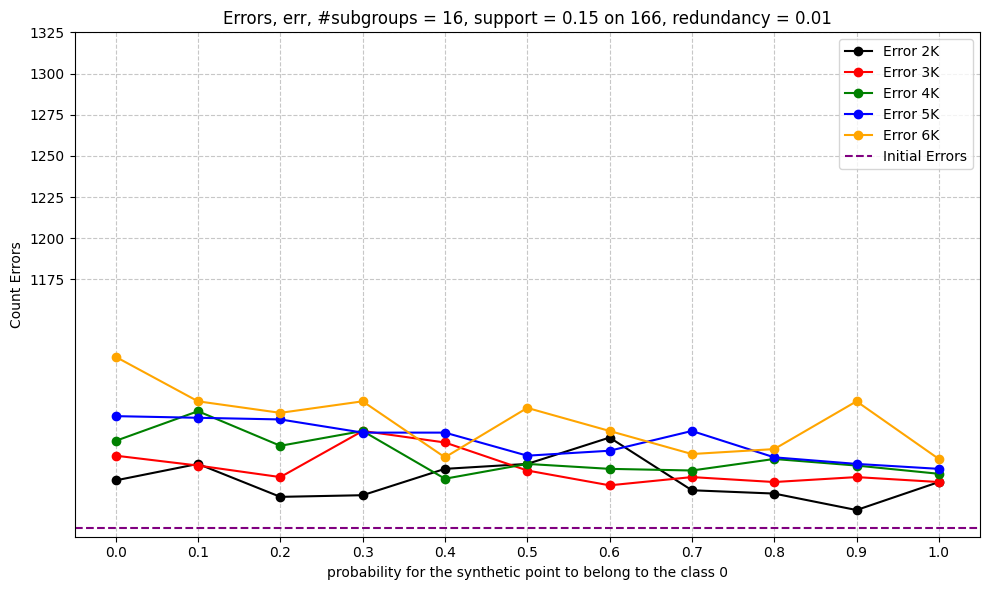

In [ ]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
p =[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Linea per i falsi positivi

plt.plot(p, errors_after_2K, marker='o', label='Error 2K ', color='black')
plt.plot(p, errors_after_3K, marker='o', label='Error 3K ', color='red')
plt.plot(p, errors_after_4K, marker='o', label='Error 4K ', color='green')
plt.plot(p, errors_after_5K, marker='o', label='Error 5K ', color='blue')
plt.plot(p, errors_after_6K,  marker='o', label='Error 6K ', color='orange')


plt.axhline(y=errors_before, color='purple', linestyle='--', label='Initial Errors')

# Etichette e titolo
plt.xlabel('probability for the synthetic point to belong to the class 0')
plt.ylabel('Count Errors')
plt.title(f'Errors, err, #subgroups = {K}, support = {min_sup} on {filtered_instances}, redundancy = 0.01')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


plt.yticks(range(1175, 1350, 25))
plt.xticks(np.arange(0, 1.1, 0.1)) 
# Mostra il grafico
plt.tight_layout()
plt.show()

In [326]:
count_1, count_0

(1147, 1645)